# Power Skill Extensions - Leading Technology Transformation - Applied Machine Learning - Utilização de autoencoders para encoding/decoding de dígitos manuscritos

##Exercício de fixação VI - Implementações de GANs padrão usando camadas totalmente conectadas e a biblioteca Keras (Dataset CIFAR-10 - Imagens em Baixa Resolução)

### Profs. Ahirton Lopes e Felipe Teodoro

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Conv2DTranspose, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import randint

In [ ]:

(train_X,train_y), (test_X, test_y) = load_data()

print('Train', train_X.shape, train_y.shape)
print('Train', test_X.shape, train_y.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Train (10000, 32, 32, 3) (50000, 1)


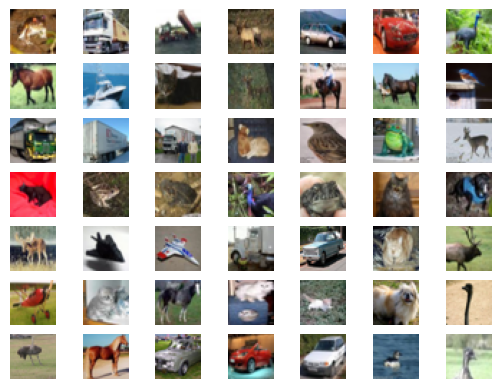

In [ ]:
for i in range(49):
    pyplot.subplot(7,7,1+i)
    pyplot.axis('off')
    pyplot.imshow(train_X[i])
pyplot.show()

In [ ]:
def discriminator(in_shape=(32,32,3)):
    model = Sequential()
    #normal
    model.add(Conv2D(64,(3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    #amostragem (downsample)
    model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #amostragem (downsample)
    model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #amostragem (downsample)
    model.add(Conv2D(256,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #classificador
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    #compilar
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# model = discriminator()
# model.summary()
# plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#carregando e preparando as imagens de treinamento CIFAR-10 (Ref. https://www.cs.toronto.edu/~kriz/cifar.html)
def load_real_samples():
    #carregando as amostras da CIFAR-10
    (trainX,_),(_,_) = load_data()
    X= trainX.astype('float32')
    X = (X-127.5)/127.5
    return X

In [ ]:
#seleção nas amostras reais
def generate_real_samples(dataset, n_samples):
    #escolhendo instâncias aleatórias
    ix = randint(0, dataset.shape[0], n_samples)
    #recuperando imagens selecionadas
    X = dataset[ix]
    #generando rótulos da classe 'real' (1)
    y = ones((n_samples, 1))
    return X, y

In [ ]:
#gerando n amostras falsas com rótulos de classe para treinar
def generate_fake_samples(n_samples):
    #generando números aleatórios uniformes em [0,1]
    X = randn(32*32*3*n_samples)
    #update para ter o intervalo[-1,1]
    X = -1 + X*2
    # remodelar (reshape) em um lote de imagens coloridas
    X = X.reshape((n_samples, 32, 32, 3))
    # gerando rótulos de classe 'falsos' (0) / colocamos rótulo de classe como 1 então
    y = zeros((n_samples,1))
    return X, y



In [ ]:
#treinando o discriminador
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch/2)
    #enumerando manualmente as épocas
    for i in range(n_iter):
        #obtendo amostras 'reais' selecionadas aleatoriamente
        X_real, y_real = generate_real_samples(dataset, half_batch)
        #atualiza discriminador em amostras reais
        _, real_acc = model.train_on_batch(X_real, y_real)
        #gerar exemplos falsos
        X_fake, y_fake = generate_fake_samples(half_batch)
        #update discriminador em amostras falsas
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        #gerando summary
        print('>%d real=%.0f%% fake=%.0f%%' %(i+1, real_acc*100, fake_acc*100))



In [ ]:
model = discriminator()
dataset = load_real_samples()
train_discriminator(model, dataset)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


>1 real=25% fake=14%
>2 real=29% fake=45%
>3 real=39% fake=49%
>4 real=43% fake=50%
>5 real=46% fake=52%
>6 real=48% fake=52%
>7 real=49% fake=52%
>8 real=50% fake=53%
>9 real=52% fake=54%
>10 real=53% fake=55%
>11 real=56% fake=58%
>12 real=58% fake=60%
>13 real=60% fake=62%
>14 real=62% fake=63%
>15 real=64% fake=66%
>16 real=66% fake=67%
>17 real=68% fake=69%
>18 real=70% fake=71%
>19 real=71% fake=72%
>20 real=73% fake=73%


In [ ]:
def generator(latent_dim):
    model = Sequential()
    #base para 4x4
    n_nodes = 256*4*4   #dando espaço para criar diferentes mapas de recursos paralelamente
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256)))

    #upsample para 8x8
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same')) #o tamanho do kernel deve ser um fator do stride tendo em vista evitar checkboarding
    model.add(LeakyReLU(alpha=0.2))

    #upsample para 16x16
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same')) #o tamanho do kernel deve ser um fator do stride tendo em vista evitar checkboarding
    model.add(LeakyReLU(alpha=0.2))

    #upsample para 32x32
    model.add(Conv2DTranspose(128,(4,4), strides=(2,2), padding='same')) #o tamanho do kernel deve ser um fator do stride tendo em vista evitar checkboarding
    model.add(LeakyReLU(alpha=0.2))

    #camada de saída
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [ ]:
#gerar pontos no espaço latente como entrada para o gerador
def generate_latent_points(latent_dim, n_samples):
    #gerar pontos no espaço latente
    x_input = randn(latent_dim * n_samples)
    #remodelar em um lote de entradas para a rede
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [ ]:
#use o gerador para gerar n exemplos falsos, com rótulos de classe (feitos de generate_fake_samples)
def fake_sampler(g_model, latent_dim, n_samples):
    X_input = generate_latent_points(latent_dim, n_samples)
    #prever saídas
    X = g_model.predict(X_input)
    #criar rótulos de classe 'falsos'(0)
    y = zeros((n_samples, 1))
    return X,y


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 4096)                │         413,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 3)           │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,466,115 (5.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step


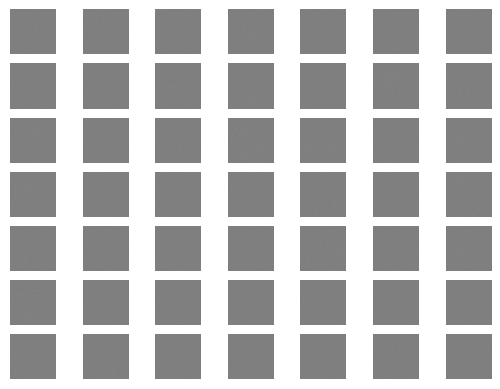

In [ ]:
latent_dim = 100 #número redondo e amplamente utilizado, mas não obrigatório
model = generator(latent_dim)
model.summary()
n_samples = 49
X, _ = fake_sampler(model, latent_dim, n_samples)
#escalando valores de pixel de [-1,1] a [0,1]
X = (X+1)/2.0
#plot
for i in range(n_samples):
    #definindo subplot
    pyplot.subplot(7,7,1+i)
    #desativa os rótulos dos eixos (off)
    pyplot.axis('off')
    pyplot.imshow(X[i])

pyplot.show()

In [ ]:
def gan(g_model, d_model):
    #fazer pesos no discriminador não treináveis
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    #compilando
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


In [ ]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model, d_model)
gan_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 32, 32, 3)           │       1,466,115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 1)                   │         522,497 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,988,612 (7.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 522,497 (1.99 MB)

In [ ]:
#treinar o modelo composto (parte da função maior abaixo)
def train_gan(gan_model, latent_dim, n_epochs=1000, n_batch=128):
    #enumerar manualmente as épocas
    for i in range(n_epochs):
        # prepara pontos no espaço latente como entrada para o gerador
        X_gan = generate_latent_points(latent_dim, n_batch)
        #crie rótulos invertidos para as amostras falsas para que o discriminador provando que é falso conte como um erro e, por sua vez, apenas os pesos do modelo dos geradores (os pesos do discriminador não são treináveis) serão atualizados para criar imagens falsas 'reais' melhores
        y_gan = ones((n_batch, 1))
        #atualiza o gerador via erro do discriminador
        gan_model.train_on_batch(X_gan, y_gan)

In [ ]:
def save_plot(examples, epoch, n=7):
    #escala de -1,1 a 0,1
    examples = (examples+1)/2.0
    #plot
    for i in range(n*n):
        #definindo subplot
        pyplot.subplot(n, n, 1+i)
        #desativa os rótulos dos eixos (off)
        pyplot.axis('off')
        #plot dados brutos de pixel
        pyplot.imshow(examples[i])
    #salvar gráfico em arquivo
    filename = 'generated_plot_e%03d.png'%(epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [ ]:
#avaliar o discriminador, plotar imagens geradas, salvar o modelo do gerador
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    #prepare amostras reais
    X_real, y_real = generate_real_samples(dataset, n_samples)
    #avaliar discriminador em amostras reais
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    #prepare exemplos falsos
    X_fake, y_fake = fake_sampler(g_model, latent_dim, n_samples)
    #eval discriminador em amostras falsas
    _, acc_fake = d_model.evaluate(X_real, y_real, verbose=0)
    # summarizando o desempenho do discriminador
    print('>Accuracy real: %.0f%%, fake: %.0f%%' %(acc_real*100, acc_fake*100))
    #salvando o plot
    save_plot(X_fake, epoch)
    # salva o arquivo do modelo do gerador
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)


In [ ]:
#treinando o gerador e o discriminador
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(dataset.shape[0]/ n_batch)
    half_batch = int(n_batch/2)
    #enumerar manualmente as épocas
    for i in range(n_epochs):
        #enumerar lotes no conjunto de treinamento
        for j in range(bat_per_epo):
            #obtenha amostras 'reais' selecionadas aleatoriamente
            X_real, y_real = generate_real_samples(dataset, half_batch)
            #update dos pesos do modelo do discriminador
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
             #gerar exemplos 'falsos'
            X_fake, y_fake = fake_sampler(g_model, latent_dim, half_batch)
             #update dos pesos do modelo do discriminador
            d_loss2, _ = d_model. train_on_batch(X_fake, y_fake)
             #prepara pontos no espaço latente como entrada para o gerador
            X_gan = generate_latent_points(latent_dim, n_batch)
             #criando rótulos invertidos para as amostras falsas
            y_gan = ones((n_batch, 1))
             #atualize o gerador via erro do discriminador
            g_loss= gan_model.train_on_batch(X_gan, y_gan)
             #summarizando a perda
            if isinstance(g_loss, list):
                g_loss = g_loss[0]  # Pegue a primeira perda se for uma lista
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if(i+1)%10==0:
         summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# tamanho do espaço latente
latent_dim = 100
#cria o discriminador
d_model = discriminator()
#cria o gerador
g_model = generator(latent_dim)
#cria a GAN
gan_model = gan(g_model, d_model)
# carrega dados da imagem
dataset = load_real_samples()
# treinando modelo
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>4, 232/390, d1=1.023, d2=1.023 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>4, 233/390, d1=1.023, d2=1.023 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>4, 234/390, d1=1.023, d2=1.024 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>4, 235/390, d1=1.023, d2=1.024 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>4, 236/390, d1=1.023, d2=1.024 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>4, 237/390, d1=1.023, d2=1.024 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>4, 238/390, d1=1.023, d2=1.024 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>4, 239/390, d1=1.023, d2=1.024 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>4, 240/390, d1=1.023, d2=1.024 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>4, 241/390, d1=1.024, d2=1.024 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>4, 242/390, d1=1.024, d2=1.024 g=0.303
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
>4, 243/390, d1=1.024, d2=1.024 g=0.303
2/2 ━━━━━━━━━

In [ ]:
 def create_plot(examples, n):
     #plotando imagens
     for i in range(n*n):
        #definindo subplot
        pyplot.subplot(n,n, 1+i)
        #desligando os eixos
        pyplot.axis('off')
        #plot dados brutos de pixel
        pyplot.imshow(examples[i, :, :])
     pyplot.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


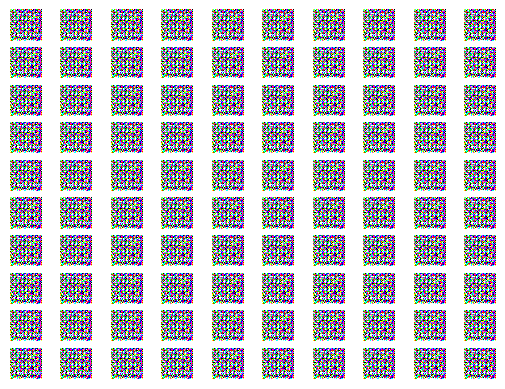

In [ ]:
from tensorflow.keras.models import load_model
#load_model
model = load_model('generator_model_010.h5')
#gerando imagens
latent_points = generate_latent_points(100,100)
X = model.predict(latent_points)
#escala de [-1,1] to [0,1]
X = (X+1)/2.0
#plotando o resultado
create_plot(X,10)
